In [17]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import RMSprop
import math
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [2]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [3]:
Dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
Dataset

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM
...,...,...,...,...,...,...
2017-12-22,151.82,153.00,151.50,152.50,2990583,IBM
2017-12-26,152.51,153.86,152.50,152.83,2479017,IBM
2017-12-27,152.95,153.18,152.61,153.13,2149257,IBM


In [4]:
# Checking for missing values
training_set = Dataset[:'2016'].iloc[:,1:2].values
test_set = Dataset['2017':].iloc[:,1:2].values

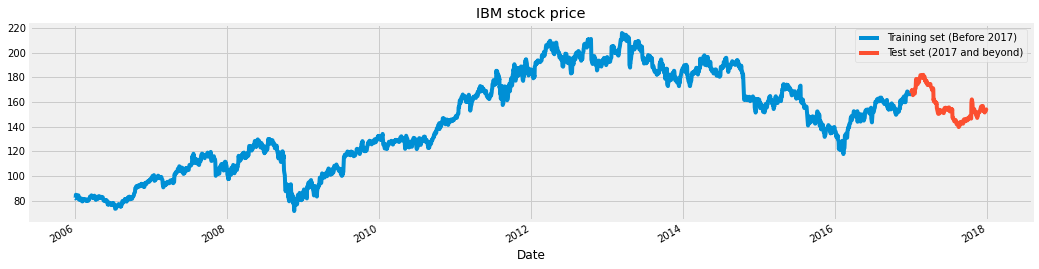

In [5]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
Dataset["Close"][:'2016'].plot(figsize=(16,4),legend=True)
Dataset["Close"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [6]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [7]:
training_set

array([[ 82.55],
       [ 82.5 ],
       [ 82.9 ],
       ...,
       [167.74],
       [166.99],
       [166.7 ]])

In [8]:
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [9]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [10]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
85/85 [==============================] - 22s 104ms/step - loss: 0.0238
Epoch 2/50
85/85 [==============================] - 8s 90ms/step - loss: 0.0098
Epoch 3/50
85/85 [==============================] - 8s 89ms/step - loss: 0.0079
Epoch 4/50
85/85 [==============================] - 8s 89ms/step - loss: 0.0068
Epoch 5/50
85/85 [==============================] - 8s 90ms/step - loss: 0.0061
Epoch 6/50
85/85 [==============================] - 8s 88ms/step - loss: 0.0052
Epoch 7/50
85/85 [==============================] - 7s 88ms/step - loss: 0.0050
Epoch 8/50
85/85 [==============================] - 7s 87ms/step - loss: 0.0047
Epoch 9/50
85/85 [==============================] - 8s 88ms/step - loss: 0.0041
Epoch 10/50
85/85 [==============================] - 8s 89ms/step - loss: 0.0038
Epoch 11/50
85/85 [==============================] - 8s 89ms/step - loss: 0.0036
Epoch 12/50
85/85 [==============================] - 8s 90ms/step - loss: 0.0033
Epoch 13/50
85/85 [================

In [11]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((Dataset["Close"][:'2016'],Dataset["Close"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [12]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

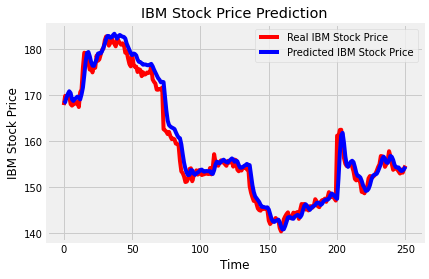

In [13]:
plot_predictions(test_set,predicted_stock_price)

In [14]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 2.1063171849782685.


In [15]:
# Create a variable to predict “x” days out into the future
predicted_stock_price = 252

 # Create a new column (as a target) and shifted “x” days up
Dataset['Prediction'] = Dataset[['Close']].shift(predicted_stock_price)
print(Dataset.tail())

              Open    High     Low   Close   Volume Name  Prediction
Date                                                                
2017-12-22  151.82  153.00  151.50  152.50  2990583  IBM      167.06
2017-12-26  152.51  153.86  152.50  152.83  2479017  IBM      166.71
2017-12-27  152.95  153.18  152.61  153.13  2149257  IBM      167.14
2017-12-28  153.20  154.12  153.20  154.04  2687624  IBM      166.19
2017-12-29  154.17  154.72  153.42  153.42  3327087  IBM      166.60
